In [296]:
# Required imports for the project
import pandas as pd
import swifter
import numpy as np
import seaborn as sns
import swifter
import dask.dataframe as dd

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import matplotlib


import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stopWords = set(stopwords.words('english') + ['la', 'de', 'however', 'pa', 'nous', 'u', 'ha'])
wordsDict = set(words.words())

from spellchecker import SpellChecker
spell = SpellChecker()


#Custom function to download datasets from airbnb site.
from utils import download_datasets

[nltk_data] Downloading package punkt to /Users/javier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/javier/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/javier/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#datasets to download
datasets_urls_boston  = [
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-09-14/data/reviews.csv.gz'
]

datasets_urls_seattle = [
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-09-14/data/reviews.csv.gz'
]

datasets_urls_losangeles = [
    'http://data.insideairbnb.com/united-states/ca/los-angeles/2018-09-08/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ca/los-angeles/2018-09-08/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/ca/los-angeles/2018-09-08/data/reviews.csv.gz'
]

download_datasets(datasets_urls_boston, 'boston_')
download_datasets(datasets_urls_seattle, 'seattle_')
download_datasets(datasets_urls_losangeles, 'losangeles_')
datasets_cities = [
    'boston',
    'seattle',
    'losangeles_'
]

losangeles_reviews.csv.gz: 0.00B [00:00, ?B/s]

File: boston_listings.csv.gz, in cache
File: boston_calendar.csv.gz, in cache
File: boston_reviews.csv.gz, in cache
File: seattle_listings.csv.gz, in cache
File: seattle_calendar.csv.gz, in cache
File: seattle_reviews.csv.gz, in cache
File: losangeles_listings.csv.gz, in cache
File: losangeles_calendar.csv.gz, in cache


losangeles_reviews.csv.gz: 138MB [03:24, 675kB/s]                               


In [3]:
#Loading DataFrames
df_reviews_raw  = pd.read_csv('losangeles_reviews.csv.gz')
df_listings_raw = pd.read_csv('losangeles_listings.csv.gz', low_memory=False)
df_calendar_raw = pd.read_csv('losangeles_calendar.csv.gz', parse_dates=['date'])

In [4]:
# Data cleanning

def cleaning_calendar(df):
    #transform 't' or 'f' into True or False values.
    df.available = df.available.apply(lambda x: x == "t")
    #remove $ sign and parse the value as numeric.
    df.price = df.price.apply(lambda x: float(str(x).replace("$","").replace(",","")))
    df.reset_index(drop=True)
    df = df.groupby('listing_id').mean()
    return df

def cleaning_listings(df):
    df = df.set_index('id')
    df.index.name = 'listing_id'
    return df

In [5]:
df_calendar = cleaning_calendar(df_calendar_raw)
df_listings = cleaning_listings(df_listings_raw)

In [6]:
df_reviews = pd.merge(df_reviews_raw, df_calendar, on='listing_id')

count    35898.000000
mean       222.824825
std        692.511495
min         10.019417
25%         72.931627
50%        116.029930
75%        198.000000
max      61000.000000
Name: price, dtype: float64


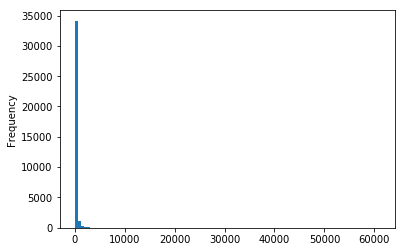

In [7]:
p75 = df_calendar.price.describe()['75%']
p50 = df_calendar.price.describe()['50%']
p25 = df_calendar.price.describe()['25%']
print(df_calendar.price.describe())
df_calendar.price.plot.hist(bins=100);

In [8]:
p75_comments = df_reviews[df_reviews.price >= p75].comments
p50_75_comments = df_reviews[df_reviews.price >= p50][df_reviews.price < p75].comments
p25_50_comments = df_reviews[df_reviews.price >= p25][df_reviews.price < p50].comments
p25_comments = df_reviews[df_reviews.price < p25].comments

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [316]:
def cleaning_comments(s):
    s = str(s)
    words = "".join([w.lower() for w in s if w.isalpha() or w == " "])
    words = "".join([w.replace("/", " ") for w in words])
    words = "".join([w.replace("\n", " ") for w in words])
    words = word_tokenize(words)
    #words = [spell.correction(w) for w in words]
    #words = [lemmatizer.lemmatize(w) for w in words]
    words = [w for w in words if w in wordsDict]
    words = [w for w in words if w not in stopWords]

    #print(s)
    #print()
    #print(words)
    #print("\n"+"="*100+"\n")
    return words

In [313]:
def train_model_word2vec(clean_comments, size=200, workers=8, window=10, min_count=10, sg=1):
    model = Word2Vec(clean_comments.values, size=200, workers=8, window=10, min_count=10, sg=1)
    return model

def plot_words(model, vocab, num_words=100, use_TSNE=False):
    words_count = [(vocab[i], i) for i in vocab]
    words_count = sorted(words_count)
    words_count.reverse()

    sorted_words = [i for _, i in words_count if i in model]
    num_words = num_words

    X = model[sorted_words[:num_words]]

    if use_TSNE:
        feat_reduction = TSNE(perplexity=40, n_components=2, init='pca', n_iter=1000, random_state=23)
    else:
        feat_reduction = PCA(n_components=2)
    result = feat_reduction.fit_transform(X)

    # create a scatter plot of the projection
    plt.figure(figsize=(20, 20))
    words = list(sorted_words[:num_words])
    for i, word in enumerate(words):
        plt.scatter(result[i, 0], result[i, 1])
        size=((words_count[i][0])*20)/words_count[0][0]
        plt.annotate(word,
             xy=(result[i, 0], result[i, 1]),
             xytext=(5, 2),
             size=10+size,
             textcoords='offset points',
             ha='right',
             va='bottom')
    plt.show()

In [62]:
p75_comments_clean = p75_comments.swifter.apply(cleaning_comments)
p50_75_comments_clean = p50_75_comments.swifter.apply(cleaning_comments)
p25_50_comments_clean = p25_50_comments.swifter.apply(cleaning_comments)
p25_comments_clean = p25_comments.swifter.apply(cleaning_comments)

Pandas Apply: 100%|██████████| 242930/242930 [02:10<00:00, 1862.02it/s]


In [63]:
all_comments_clean = pd.concat([p75_comments_clean, p50_75_comments_clean, p25_50_comments_clean, p25_comments_clean])

In [297]:
#model = train_model_word2vec(all_comments_clean, window=20, min_count=200)
model2 = KeyedVectors.load_word2vec_format('~/Downloads/GoogleNews-vectors-negative300.bin', binary=True)

In [238]:
def count_words(comments_clean):
    words_count = dict()
    for sentence in comments_clean:
        for word in sentence:
            if word in words_count:
                words_count[word] += 1
            else:
                words_count[word] = 0
    return words_count

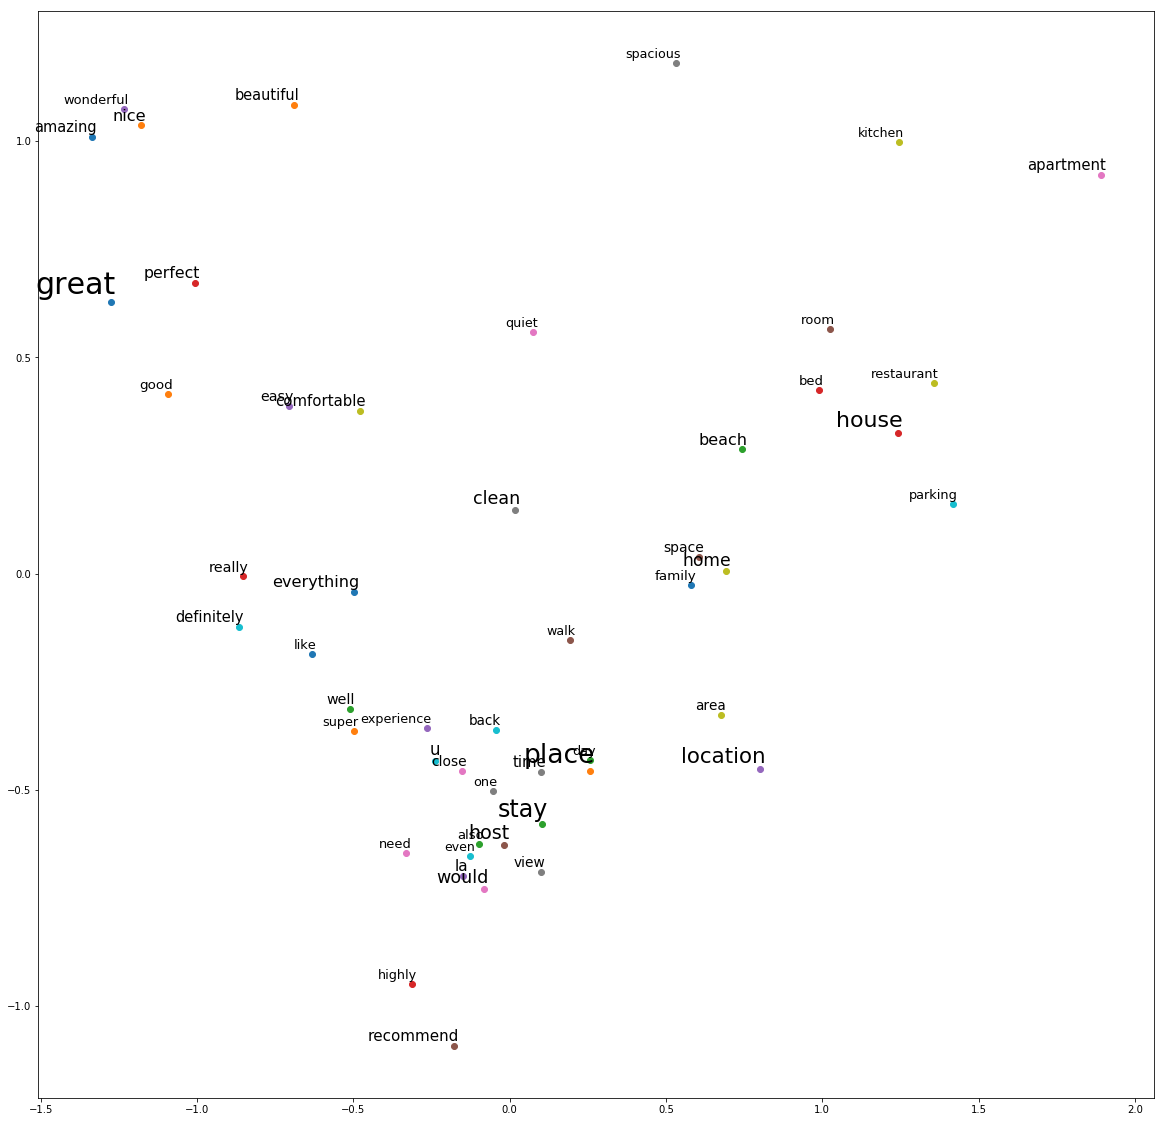

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


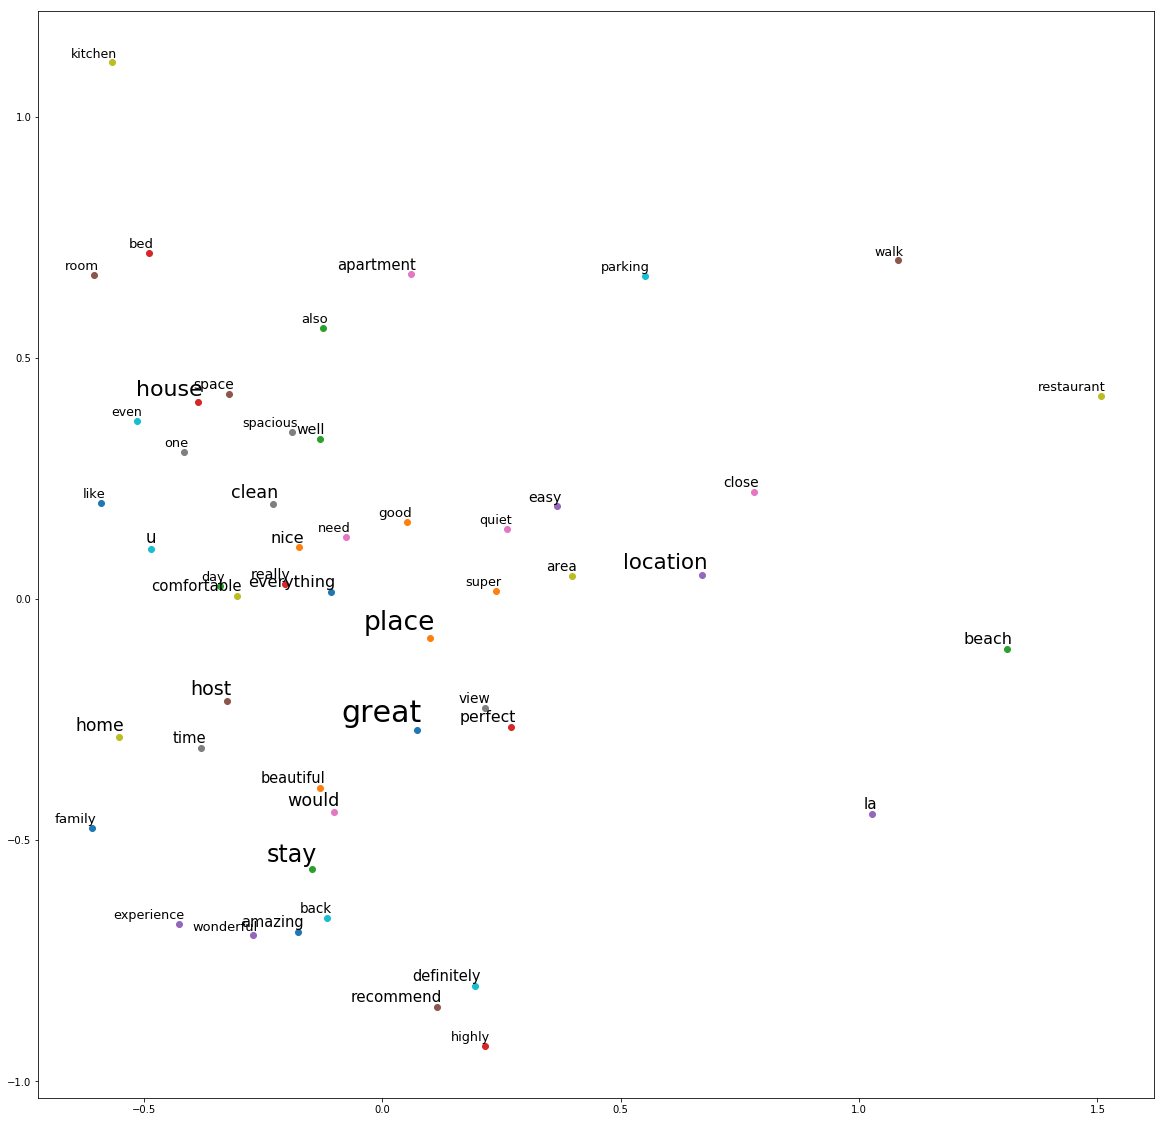

In [299]:
plot_words(model2, count_words(p75_comments_clean), 50)
plot_words(model, count_words(p75_comments_clean), 50)

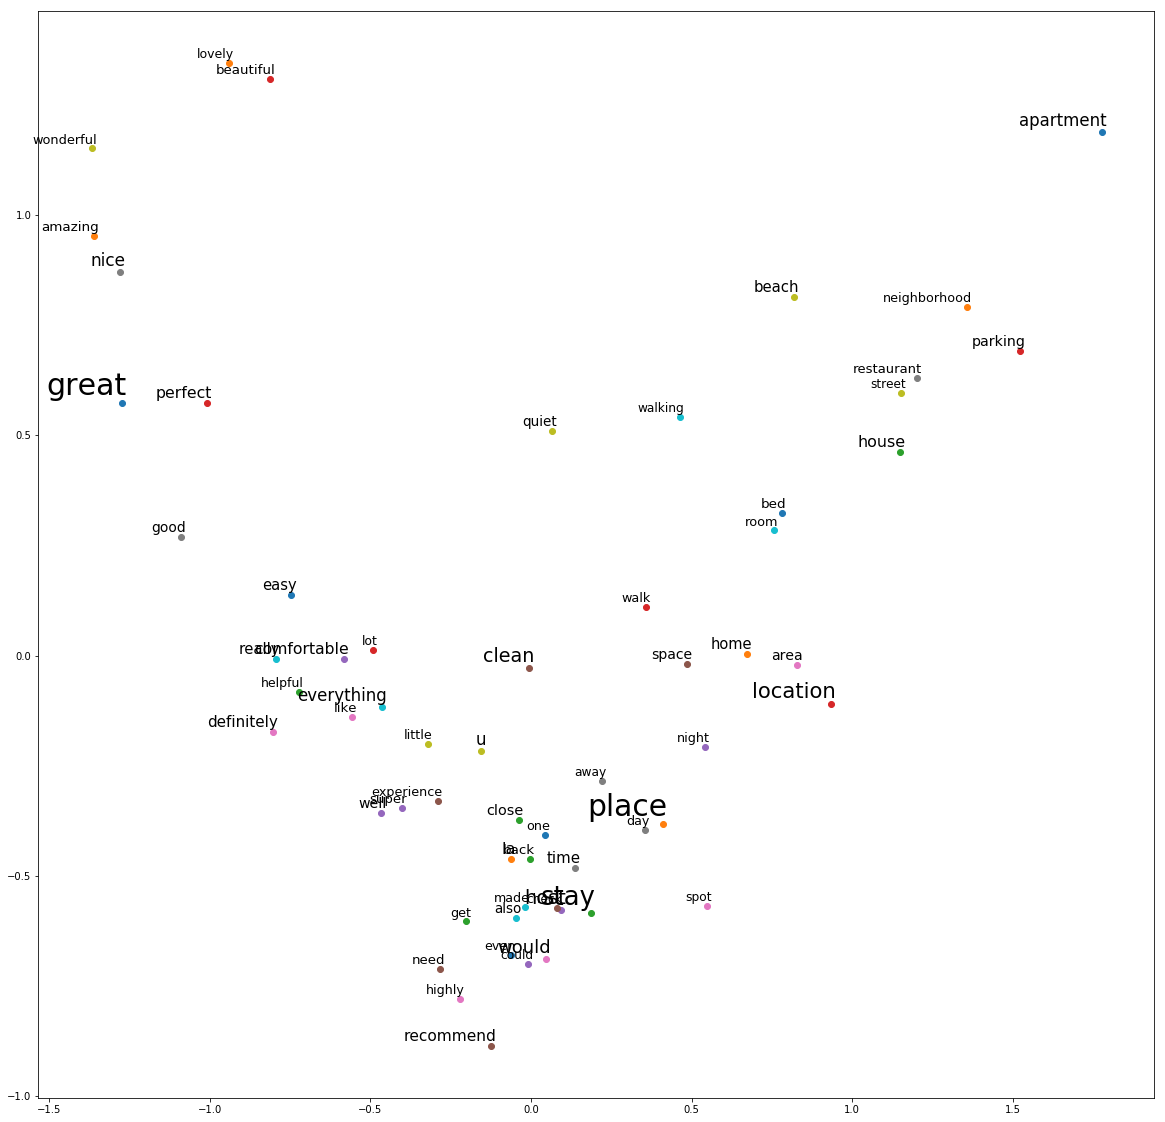

In [300]:
plot_words(model2, count_words(p50_75_comments_clean), 60)

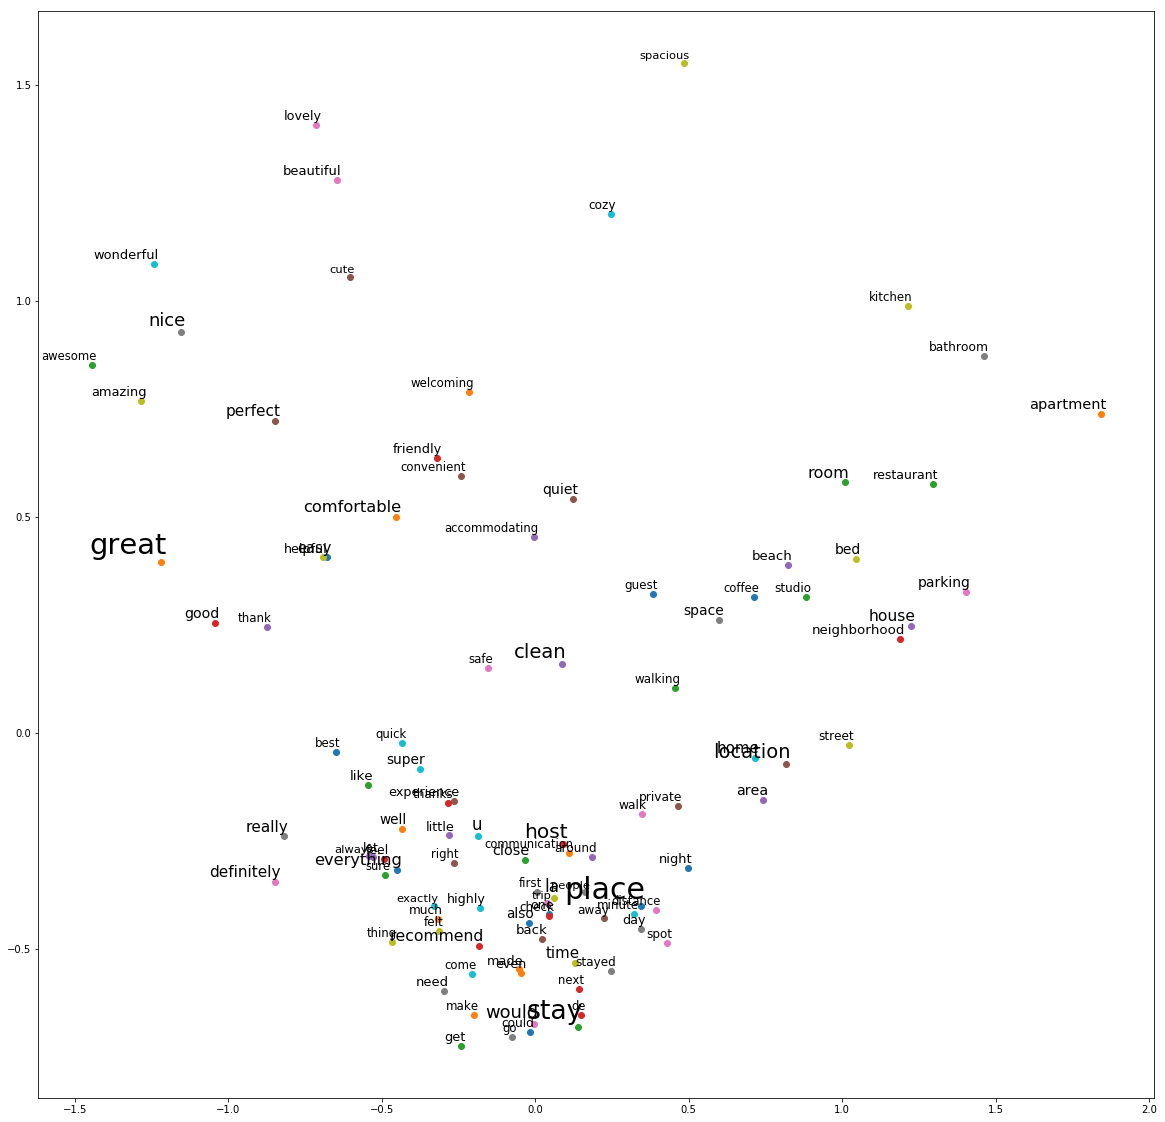

In [314]:
plot_words(model2, count_words(p25_50_comments_clean))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


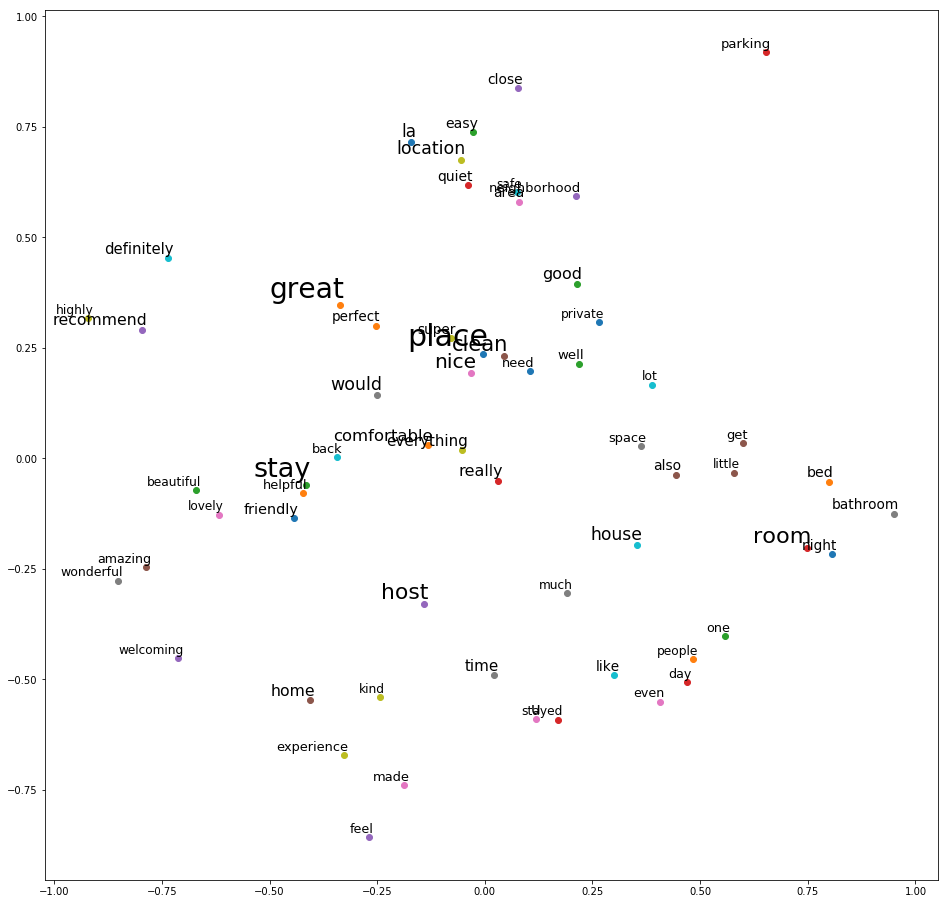

In [242]:
plot_words(model, count_words(p25_comments_clean), 60)

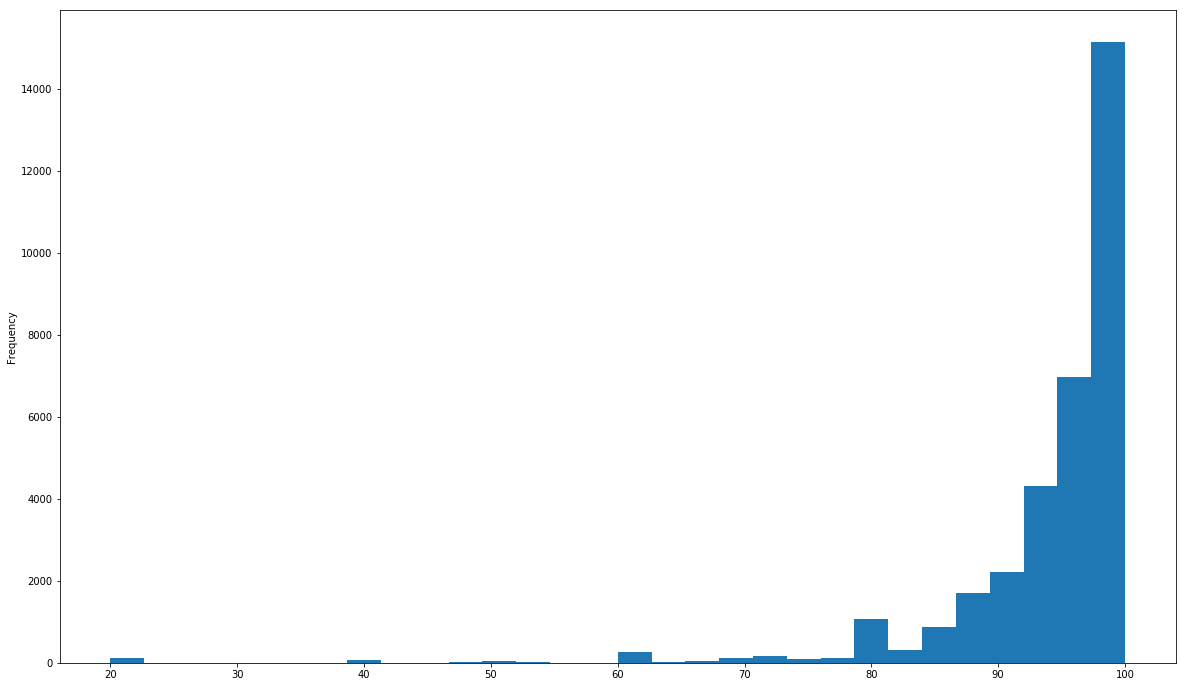

In [243]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 12)
df_listings['review_scores_rating'].plot.hist(bins=30)

In [244]:
df = pd.merge(df_reviews, df_listings, on='listing_id')

In [245]:
bad_comments = df[df.review_scores_rating <= 20].comments.swifter.apply(cleaning_comments)

Pandas Apply: 100%|██████████| 132/132 [00:00<00:00, 1170.74it/s]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


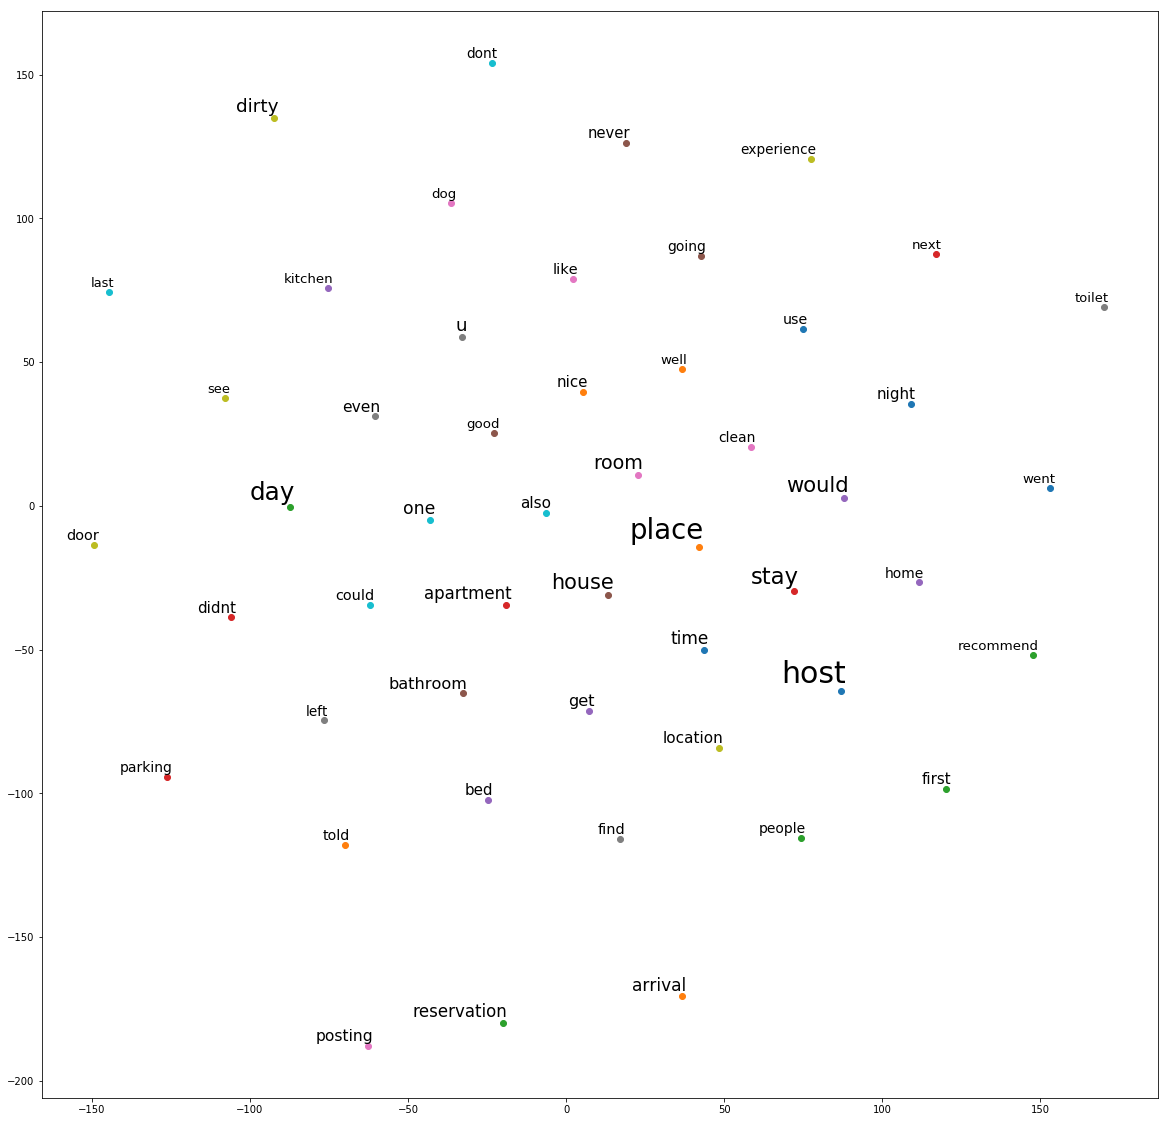

In [291]:
plot_words(model, count_words(bad_comments), 50, True)

In [247]:
pd.set_option('display.max_columns', 500)

In [248]:
display(df.review_scores_accuracy.describe())
display(df.review_scores_checkin.describe())
display(df.review_scores_cleanliness.describe())
display(df.review_scores_communication.describe())
display(df.review_scores_location.describe())
display(df.review_scores_rating.describe())
display(df.review_scores_value.describe())

count    1.162443e+06
mean     9.754457e+00
std      4.785910e-01
min      2.000000e+00
25%      1.000000e+01
50%      1.000000e+01
75%      1.000000e+01
max      1.000000e+01
Name: review_scores_accuracy, dtype: float64

count    1.162391e+06
mean     9.881654e+00
std      3.544637e-01
min      2.000000e+00
25%      1.000000e+01
50%      1.000000e+01
75%      1.000000e+01
max      1.000000e+01
Name: review_scores_checkin, dtype: float64

count    1.162439e+06
mean     9.568664e+00
std      6.144781e-01
min      2.000000e+00
25%      9.000000e+00
50%      1.000000e+01
75%      1.000000e+01
max      1.000000e+01
Name: review_scores_cleanliness, dtype: float64

count    1.162438e+06
mean     9.869761e+00
std      3.754995e-01
min      2.000000e+00
25%      1.000000e+01
50%      1.000000e+01
75%      1.000000e+01
max      1.000000e+01
Name: review_scores_communication, dtype: float64

count    1.162380e+06
mean     9.703167e+00
std      5.213107e-01
min      2.000000e+00
25%      9.000000e+00
50%      1.000000e+01
75%      1.000000e+01
max      1.000000e+01
Name: review_scores_location, dtype: float64

count    1.162490e+06
mean     9.517593e+01
std      4.310009e+00
min      2.000000e+01
25%      9.300000e+01
50%      9.600000e+01
75%      9.800000e+01
max      1.000000e+02
Name: review_scores_rating, dtype: float64

count    1.162369e+06
mean     9.574534e+00
std      5.494621e-01
min      2.000000e+00
25%      9.000000e+00
50%      1.000000e+01
75%      1.000000e+01
max      1.000000e+01
Name: review_scores_value, dtype: float64

Pandas Apply: 100%|██████████| 131/131 [00:00<00:00, 1653.23it/s]


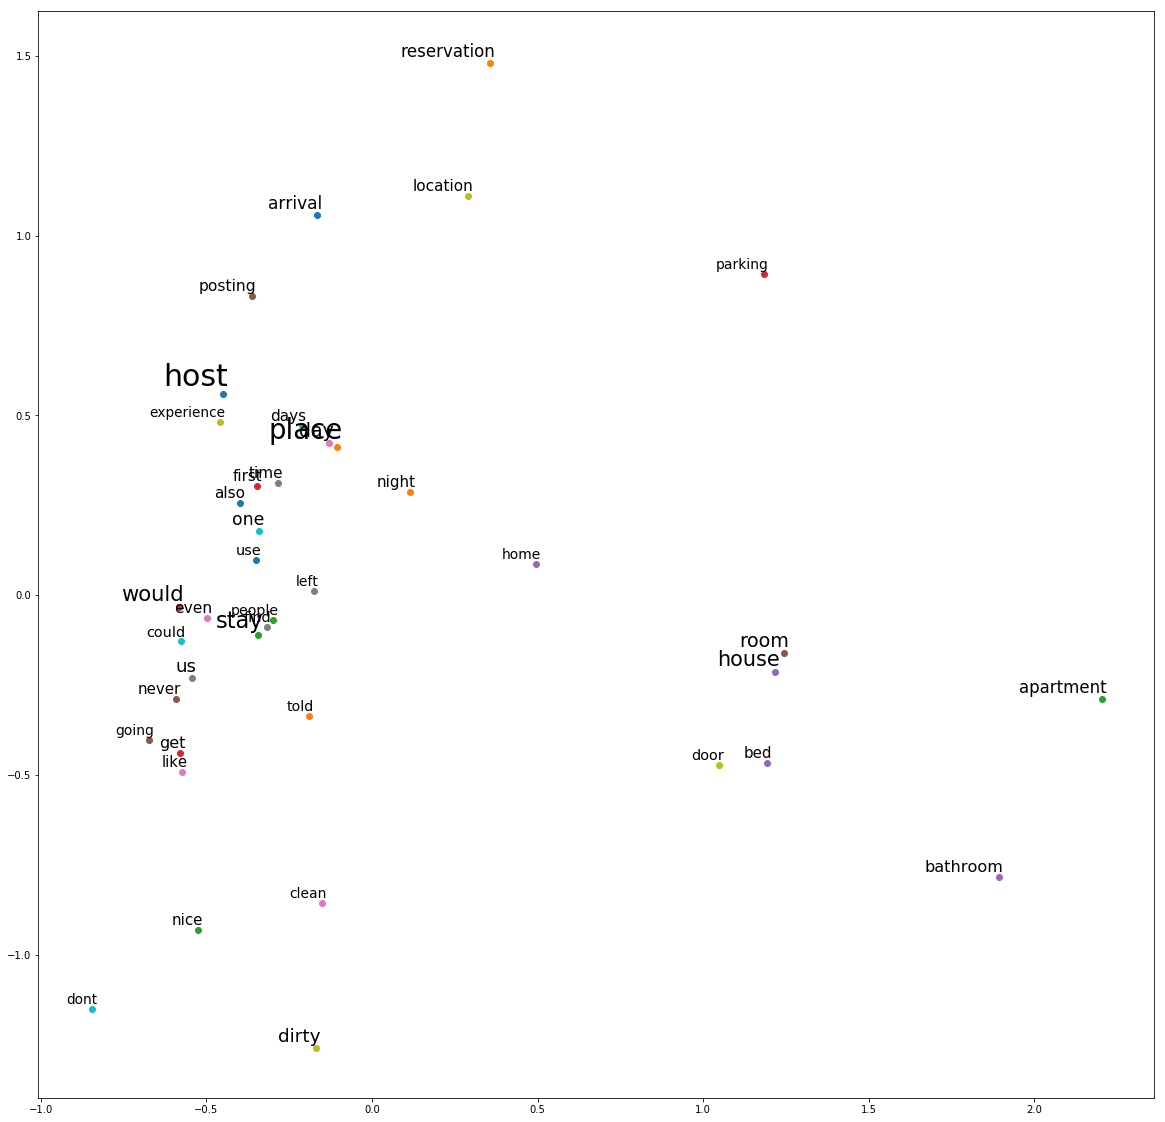

In [320]:
bad_comments = df[df.review_scores_cleanliness <= 2].comments.swifter.apply(cleaning_comments)
plot_words(model2, count_words(bad_comments), 40)
#df[df.review_scores_cleanliness <= 2].comments

Pandas Apply: 100%|██████████| 64/64 [00:00<00:00, 1851.43it/s]


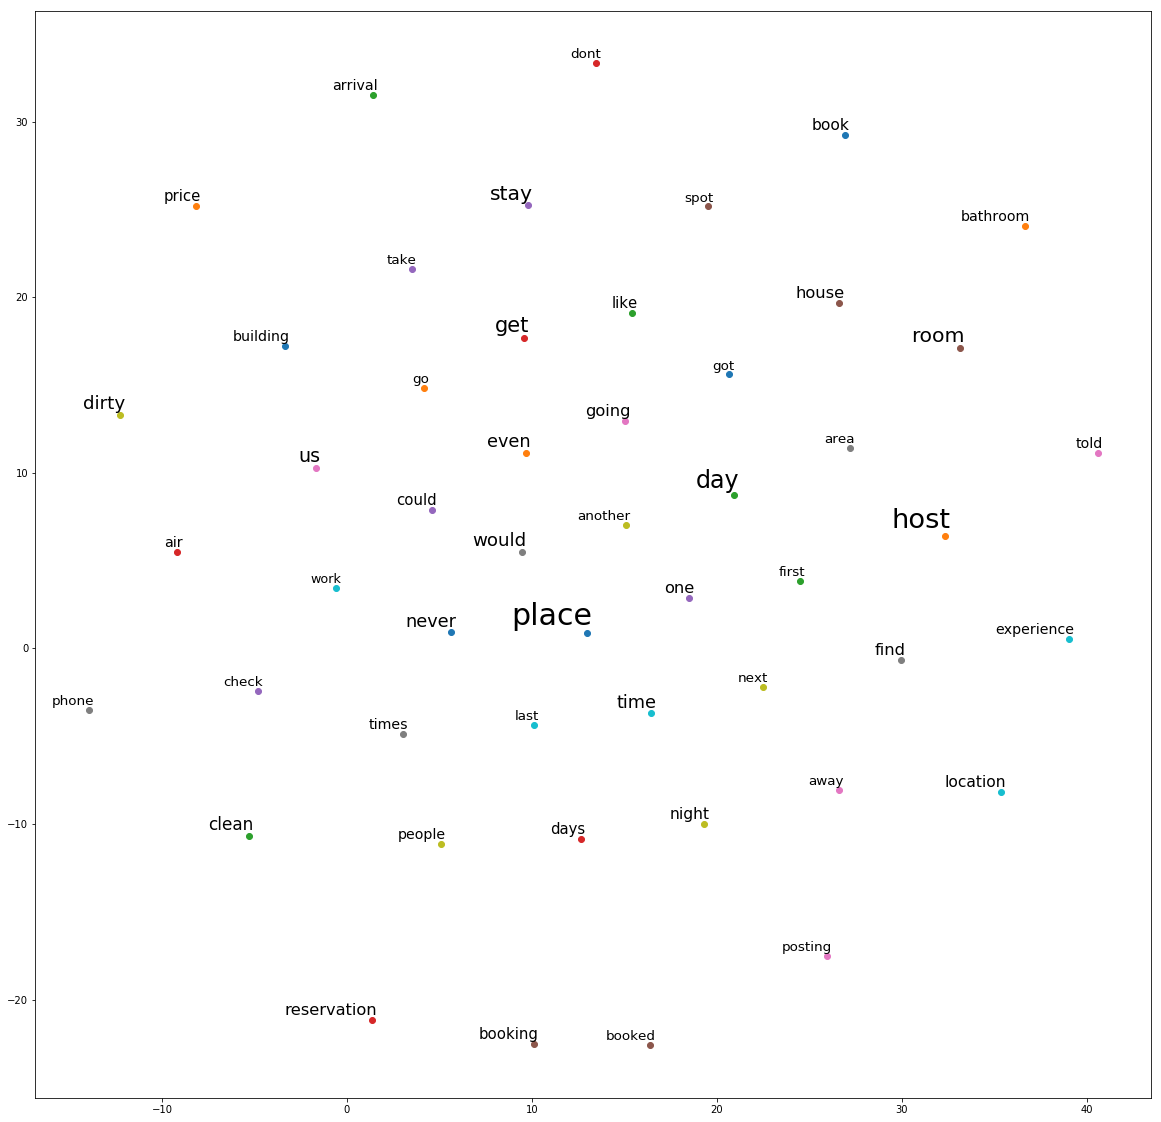

(64, 103)

In [319]:
bad_comments = df[df.review_scores_location <= 2].comments.swifter.apply(cleaning_comments)
plot_words(model2, count_words(bad_comments), 50, True)
df[df.review_scores_location <= 2].shape

Pandas Apply: 100%|██████████| 110/110 [00:00<00:00, 976.33it/s] 
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


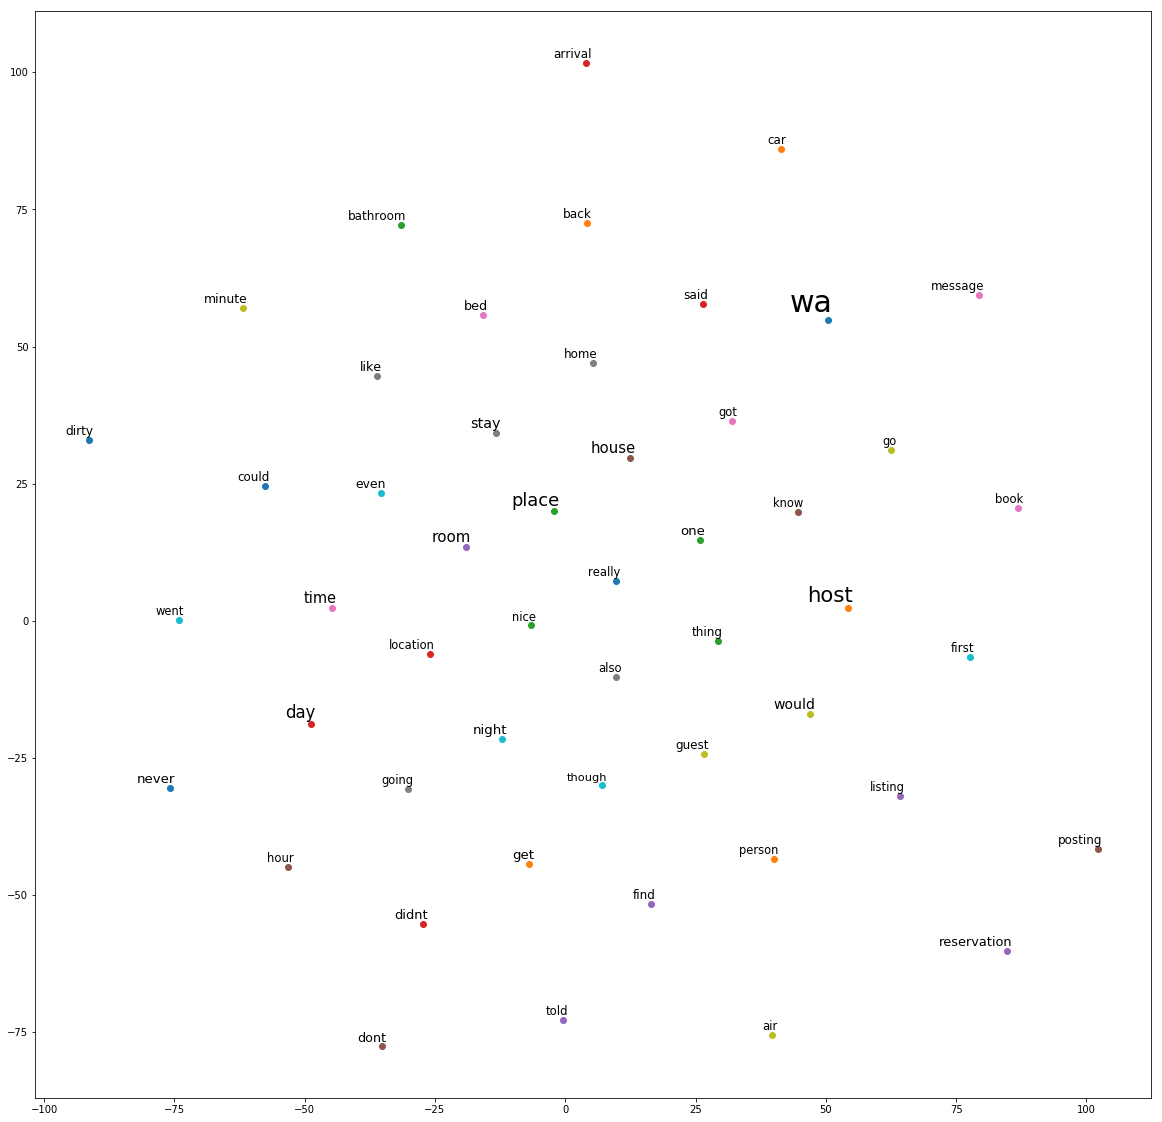

(110, 103)

In [305]:
bad_comments = df[df.review_scores_communication <= 2].comments.swifter.apply(cleaning_comments)
plot_words(model, count_words(bad_comments), 50, True)
df[df.review_scores_communication <= 2].shape

In [325]:
df.groupby('listing_id').comments.count()

listing_id
109           2
344           3
2708         12
2732         17
3021         21
5728        187
5729        118
5843         62
6033         22
7143        170
7992        118
8021        212
8235        148
8770        365
9140        343
9376         35
9545        124
10760        44
11374        12
11511         7
11877        35
12320         2
13776       143
14098        16
14106        14
14107        30
14124       134
14273        47
14337         1
14945        16
           ... 
28163578      1
28164648      1
28169497      1
28180887      1
28183497      2
28186746      1
28188413      1
28188894      2
28192411      1
28193959      2
28200877      1
28202971      1
28204800      1
28210649      1
28218510      1
28227540      1
28230598      1
28232526      2
28249109      1
28253923      1
28259690      2
28274887      1
28277953      1
28281174      1
28282321      1
28289391      1
28313832      1
28314083      1
28338906      1
28346212      1
Name: comment